In [1]:
import librosa as lb
import os
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from glob import glob
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, Flatten, LSTM, MaxPool2D, ConvLSTM2D, GRU, BatchNormalization
from librosa import load
from librosa.feature import mfcc
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 25
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION
NUM_MFCCS = 50

In [3]:
def load_audio(folder):
    # load original mp3s
    loaded_mp3_files = [load(f) for f in glob(folder + '*.mp3')[:100]]
    
    # make same length
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    
    mfccs = [mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs

In [4]:
def normalize_audio(source_files):
    fixed_lengths = [lb.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]

In [5]:
# def flatten_input(input):
#     return np.array([x.reshape(x.shape[0] * x.shape[1]) for x in input])

In [6]:
english_X = load_audio('../data/speech-accent-archive/recordings/english/')
spanish_X = load_audio('../data/speech-accent-archive/recordings/spanish/')
arabic_X = load_audio('../data/speech-accent-archive/recordings/arabic/')
mandarin_X = load_audio('../data/speech-accent-archive/recordings/mandarin/')
french_X = load_audio('../data/speech-accent-archive/recordings/french/')

In [7]:
print(len(english_X))
english_X[0].shape
# flattened_us_X = flatten_input(us_X)
# flattened_uk_X = flatten_input(uk_X)
# flattened_hk_X = flatten_input(hk_X)
# flattened_cn_X = flatten_input(cn_X)
# flattened_ger_X = flatten_input(ger_X)

100


(50, 1077)

In [8]:
X = np.concatenate([english_X, spanish_X, arabic_X, mandarin_X, french_X])
Y = np.zeros(len(english_X) + len(spanish_X) + len(arabic_X) + len(mandarin_X) + len(french_X))
Y[21:40] = 1
Y[41:60] = 2
Y[61:80] = 3
Y[81:100] = 4

In [9]:
Y_categorical = to_categorical(Y)
print(X.shape)
print(Y_categorical.shape)

(428, 50, 1077)
(428, 5)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.09, random_state=1337)

In [11]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(389, 50, 1077)
(389, 5)
(39, 50, 1077)
(39, 5)


In [ ]:
def ff_model(X_train, y_train, X_test, y_test):
    print(X_train.shape)
    print(X_test.shape)
    
    X_val = X_train[:30]
    y_val = y_train[:30]
    X_train_true = X_train[30:]
    y_train_true = y_train[30:]
    
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(53850,)))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [ ]:
ffmodel, ffhistory = ff_model(X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), 
                              y_train, 
                              X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]), 
                              y_test)

In [12]:
def plot_train_val_acc(history):
    # Plot train-val accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [13]:
def plot_train_val_loss(history):
    # Plot tran-val loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [ ]:
plot_train_val_acc(ffhistory)
plot_train_val_loss(ffhistory)

In [ ]:
def cnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[:20]
    y_val = y_train[:20]
    X_train_true = X_train[20:]
    y_train_true = y_train[20:]
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 1077, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val), 
              callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
cnnmodel, cnnhistory = cnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
                      y_test)

In [ ]:
plot_train_val_acc(cnnhistory)
plot_train_val_loss(cnnhistory)

In [24]:
def rnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[-50:]
    y_val = y_train[-50:]
    X_train_true = X_train[:-50]
    y_train_true = y_train[:-50]
    
    print(X_train.shape)
    print(X_train_true.shape)
    print(X_val.shape)
    
    model = Sequential()
    model.add(LSTM(128, input_shape=(50, 1077), recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(256, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(512, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
    model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0000002), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, batch_size=512, epochs=256, validation_data=(X_val, y_val), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [25]:
rnnmodel, rnnhistory = rnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2]), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2]), 
                      y_test)

(389, 50, 1077)
(339, 50, 1077)
(50, 50, 1077)
Train on 339 samples, validate on 50 samples
Epoch 1/256
339/339 [==============================] - 21s 63ms/step - loss: 5.8372 - acc: 0.4926 - val_loss: 5.8398 - val_acc: 0.6200
Epoch 2/256
339/339 [==============================] - 13s 39ms/step - loss: 5.8375 - acc: 0.4720 - val_loss: 5.8396 - val_acc: 0.6200
Epoch 3/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8380 - acc: 0.4572 - val_loss: 5.8395 - val_acc: 0.6200
Epoch 4/256
339/339 [==============================] - 9s 27ms/step - loss: 5.8372 - acc: 0.4749 - val_loss: 5.8394 - val_acc: 0.6200
Epoch 5/256
339/339 [==============================] - 10s 29ms/step - loss: 5.8359 - acc: 0.5280 - val_loss: 5.8393 - val_acc: 0.6200
Epoch 6/256
339/339 [==============================] - 10s 30ms/step - loss: 5.8382 - acc: 0.4631 - val_loss: 5.8392 - val_acc: 0.6200
Epoch 7/256
339/339 [==============================] - 11s 33ms/step - loss: 5.8370 - acc: 0.4808 -

Epoch 61/256
339/339 [==============================] - 12s 35ms/step - loss: 5.8308 - acc: 0.5634 - val_loss: 5.8330 - val_acc: 0.7000
Epoch 62/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8303 - acc: 0.5664 - val_loss: 5.8328 - val_acc: 0.7000
Epoch 63/256
339/339 [==============================] - 12s 35ms/step - loss: 5.8301 - acc: 0.5811 - val_loss: 5.8327 - val_acc: 0.7000
Epoch 64/256
339/339 [==============================] - 12s 35ms/step - loss: 5.8311 - acc: 0.5487 - val_loss: 5.8326 - val_acc: 0.7000
Epoch 65/256
339/339 [==============================] - 13s 39ms/step - loss: 5.8308 - acc: 0.5664 - val_loss: 5.8325 - val_acc: 0.7000
Epoch 66/256
339/339 [==============================] - 12s 36ms/step - loss: 5.8285 - acc: 0.6077 - val_loss: 5.8324 - val_acc: 0.7200
Epoch 67/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8297 - acc: 0.6106 - val_loss: 5.8323 - val_acc: 0.7200
Epoch 68/256
339/339 [==========================

339/339 [==============================] - 11s 32ms/step - loss: 5.8220 - acc: 0.6460 - val_loss: 5.8261 - val_acc: 0.7600
Epoch 122/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8230 - acc: 0.6785 - val_loss: 5.8260 - val_acc: 0.7800
Epoch 123/256
339/339 [==============================] - 12s 34ms/step - loss: 5.8232 - acc: 0.6637 - val_loss: 5.8259 - val_acc: 0.7800
Epoch 124/256
339/339 [==============================] - 11s 31ms/step - loss: 5.8250 - acc: 0.6283 - val_loss: 5.8258 - val_acc: 0.7800
Epoch 125/256
339/339 [==============================] - 11s 31ms/step - loss: 5.8221 - acc: 0.6873 - val_loss: 5.8257 - val_acc: 0.7800
Epoch 126/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8218 - acc: 0.6490 - val_loss: 5.8256 - val_acc: 0.7800
Epoch 127/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8213 - acc: 0.6637 - val_loss: 5.8254 - val_acc: 0.7800
Epoch 128/256
339/339 [==============================] 

Epoch 181/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8155 - acc: 0.7286 - val_loss: 5.8193 - val_acc: 0.7800
Epoch 182/256
339/339 [==============================] - 11s 33ms/step - loss: 5.8159 - acc: 0.7198 - val_loss: 5.8192 - val_acc: 0.7800
Epoch 183/256
339/339 [==============================] - 11s 32ms/step - loss: 5.8154 - acc: 0.7257 - val_loss: 5.8191 - val_acc: 0.7800
Epoch 184/256
339/339 [==============================] - 13s 37ms/step - loss: 5.8138 - acc: 0.7611 - val_loss: 5.8190 - val_acc: 0.7800
Epoch 185/256
339/339 [==============================] - 11s 34ms/step - loss: 5.8151 - acc: 0.7257 - val_loss: 5.8188 - val_acc: 0.8000
Epoch 186/256
339/339 [==============================] - 12s 35ms/step - loss: 5.8161 - acc: 0.7316 - val_loss: 5.8187 - val_acc: 0.8000
Epoch 187/256
339/339 [==============================] - 11s 33ms/step - loss: 5.8164 - acc: 0.7139 - val_loss: 5.8186 - val_acc: 0.8000
Epoch 188/256
339/339 [==================

339/339 [==============================] - 9s 25ms/step - loss: 5.8081 - acc: 0.7758 - val_loss: 5.8124 - val_acc: 0.8000
Epoch 242/256
339/339 [==============================] - 9s 25ms/step - loss: 5.8092 - acc: 0.7670 - val_loss: 5.8123 - val_acc: 0.8000
Epoch 243/256
339/339 [==============================] - 8s 25ms/step - loss: 5.8075 - acc: 0.7670 - val_loss: 5.8122 - val_acc: 0.8000
Epoch 244/256
339/339 [==============================] - 10s 28ms/step - loss: 5.8088 - acc: 0.7670 - val_loss: 5.8121 - val_acc: 0.8000
Epoch 245/256
339/339 [==============================] - 11s 33ms/step - loss: 5.8084 - acc: 0.7729 - val_loss: 5.8120 - val_acc: 0.8000
Epoch 246/256
339/339 [==============================] - 10s 30ms/step - loss: 5.8072 - acc: 0.7699 - val_loss: 5.8118 - val_acc: 0.8000
Epoch 247/256
339/339 [==============================] - 10s 29ms/step - loss: 5.8065 - acc: 0.7699 - val_loss: 5.8117 - val_acc: 0.8000
Epoch 248/256
339/339 [==============================] - 8

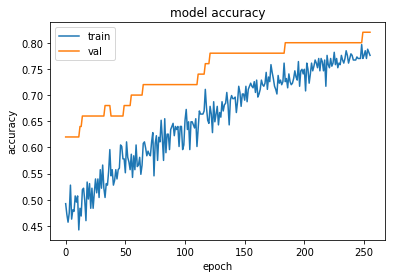

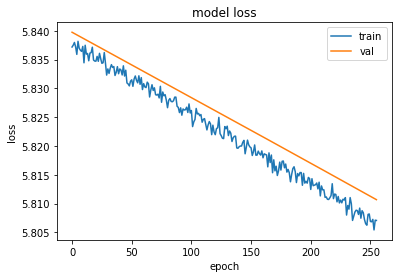

In [26]:
plot_train_val_acc(rnnhistory)
plot_train_val_loss(rnnhistory)